# 模态I CHAMBER=4基于单变量轨迹的稳定时段划分
来自文兰硕士论文（基于单变量轨迹的时段划分）：针对模态I/CHAMBER=4的单个变量（保持环压力）的时段划分
时段划分模型：文兰硕士论文第4章节

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import tqdm as tqdm

import pickle

%matplotlib inline

In [2]:
data = pd.read_csv('./data phm 2016/Train_data_modeI_chamber4_mm.csv')
data = data.drop(['Unnamed: 0'], axis=1)

In [42]:
# 保存wafer id
wafer_id_train = []
for wafer_id, group in data.groupby(['WAFER_ID']):
    if wafer_id==4167773580: # 这片分不出5个稳定时段所以删掉了
        pass
    else:
        wafer_id_train.append(wafer_id)
with open('./data phm 2016/wafer_id_train_seg.list', 'wb') as f:
    pickle.dump(wafer_id_train, f)

In [3]:
# 抽取保持环压力变量
df_data = data[['WAFER_ID', 'RETAINER_RING_PRESSURE']]
data_group = df_data.groupby(by=['WAFER_ID'])

(-5.0, 220.0)

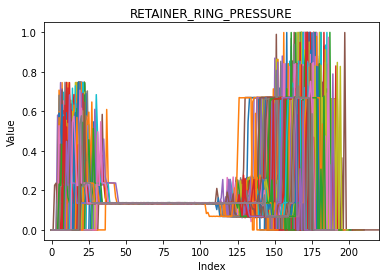

In [4]:
# plot curve
fig = plt.figure(figsize=(6,4))
for wafer_id, group in data_group:
    l = len(group['RETAINER_RING_PRESSURE'])
    plt.plot(range(0,l), group['RETAINER_RING_PRESSURE'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('RETAINER_RING_PRESSURE')
plt.xlim(-5,220)

## step1:基于单变量轨迹的时段划分

In [5]:
# 基于单变量轨迹的时段划分
# 论文设计的时段划分点是左闭右开的，所以b_right是i+1
# Ls = 稳定时段的最小长度
def time_segment(dseq, theta1, theta2, Ls):
    b_left = []
    b_right = []
    
    for i in range(1, len(dseq)-1):
        if (dseq[i]-dseq[i+1] <= theta1) & (np.std([dseq[i-1],dseq[i],dseq[i+1]]) >= theta2):
            b_left.append(i)
        if (dseq[i]-dseq[i-1] <= theta1) & (np.std([dseq[i-1],dseq[i],dseq[i+1]]) >= theta2):
            b_right.append(i+1)
    b = np.hstack([0, b_left, b_right, len(dseq)]) # 修改～～～
    b.sort()
    
    n_stable_seg = 0
    b_stable = []
#     for x,y in zip(b[:-1], b[1:]):
#         if y-x >= Ls:
#             n_stable_seg += 1
#     # 合并时段长度过少的时段（方法1，方法划分结果一般）
#     i, j =0, 1
#     while j<len(b):
#         if b[j]-b[i]>=Ls:
#             b_stable.append(b[i])
#             i = j
#             j = i+1
#             n_stable_seg += 1
            
#         else:
#             j += 1
#     合并时段长度过少的时段（方法2这种方法最好，最后采用了这种方法）
    for i,j in zip(b[:-1], b[1:]):
        if j-i >= Ls:
            b_stable.append(i)
            b_stable.append(j)
            n_stable_seg += 1
    
    '''
    返回值：
    n_stable_seg:稳定时段的个数
    b_stable:list-wise,顺序是左起点、右起点、左起点、右起点， e.g.[0,18,27,145]表示第1个稳定时段是[0,18)，第2个稳定时段是[28,145)
    b: list-wise, b_left和b_right直接组合在一起
    b_left: list-wise,所有的左起点
    b_right: list-wise，所有的右起点
    '''
    return n_stable_seg, b_stable, b, b_left, b_right

In [6]:
# 绘图函数，绘制RETAINER_RING_PRESSURE轨迹和起止点的坐标
def plot_curve(dseq:list, b_stable:list):
    """
    dseq: RETAINER_RING_PRESSURE的轨迹
    b_stable: 分割点，格式是[a,b,c,d]表示[a,b),[c,d)是两个时段
    """
    f = plt.figure(figsize=(10,5))
    plt.plot(dseq)
    plt.scatter(b_stable[0:-1:2], dseq[b_stable[0:-1:2]], s=5, lw=3, c='red') # 左起点
    plt.scatter(b_stable[1:-1:2], dseq[b_stable[1:-1:2]], s=5, lw=3, c='green') # 右终点
    # plt.scatter(b_right, dseq[b_right], s=5, lw=3, c='green')
    # plt.scatter(range(128,134), dseq[128:134], s=5, lw=3, c='orange')
    # plt.scatter(range(161,165), dseq[161:165], s=5, lw=3, c='green')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

def plot_bar(df_stable_seg:pd.DataFrame):
    segment_count = df_stable_seg['n_stable_segment'].value_counts()
    segment_count = (list(segment_count.index), list(segment_count.values))
    plt.figure()
    plt.bar(segment_count[0], segment_count[1], color='white', edgecolor='black', linewidth=1)
    for x,y in zip(segment_count[0], segment_count[1]):
        plt.text(x-0.15, y+0.6, y)
    plt.xlabel('Number of Segment')
    plt.ylabel('Number of Batch')
    plt.show()

3
[0, 16, 25, 134, 135, 150]
[  0  16  17  18  19  24  24  25 134 134 135 150 151 151 152 153 154 159
 159 160 161 162 166]
[16, 18, 24, 134, 150, 151, 152, 153, 154, 159, 161]
[17, 19, 24, 25, 134, 135, 151, 159, 160, 162]


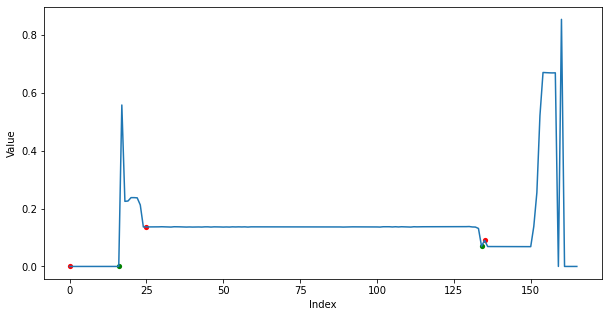

In [7]:
# one case for test-4216160666
# 4167773580
dseq = data_group.get_group(3031014466)['RETAINER_RING_PRESSURE'].values
n_stable_seg, b_stable, b, b_left, b_right = time_segment(dseq, 0.01, 0.015, 7)
print(n_stable_seg)
print(b_stable)
print(b)
print(b_left)
print(b_right)

plot_curve(dseq, b_stable)

In [8]:
# 统计粗略划分的稳定时段个数
# (0.01, 0.1, 5)配合方法1这组参数可以
# (0.01, 0.04, 5)配合方法1这组参数可以
# (0.01, 0.015, 7)配合方法2效果最好
df_stable_seg = pd.DataFrame(columns=['WAFER_ID', 'n_stable_segment', 'b_stable'])
for wafer_id, group in data_group:
    dseq = group['RETAINER_RING_PRESSURE'].values
    n_stable_seg, b_stable, b, b_left, b_right = time_segment(dseq, 0.01, 0.015, 7)
    df_stable_seg = df_stable_seg.append({'WAFER_ID':wafer_id, 'n_stable_segment':n_stable_seg, 'b_stable':b_stable}, ignore_index=True)

df_stable_seg = df_stable_seg.set_index('WAFER_ID')
df_stable_seg
# 划分结果df_stable_seg的说明
# n_stable_segment表示时段的个数
# b_stable表示时段的左起点和右终点,例如[0,17,25,138]表示[0,17)和[25,138)两个时段

,n_stable_segment,b_stable
WAFER_ID,,
-4230160598,5,"[0, 17, 25, 138, 142, 154, 159, 169, 173, 187]"
-4230160428,5,"[0, 16, 25, 138, 141, 155, 158, 170, 176, 187]"
-4230160424,5,"[0, 17, 25, 138, 141, 156, 161, 171, 177, 188]"
-4230160408,5,"[0, 17, 25, 138, 141, 154, 160, 170, 173, 187]"
-4228160702,5,"[0, 17, 25, 140, 143, 157, 162, 172, 173, 189]"
...,...,...
4229773652,5,"[0, 17, 26, 125, 133, 159, 164, 174, 178, 191]"
4229773698,5,"[0, 9, 18, 132, 134, 150, 155, 165, 171, 183]"
4229773718,5,"[0, 19, 25, 138, 144, 158, 163, 173, 176, 190]"


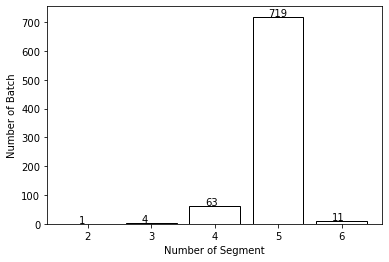

In [9]:
plot_bar(df_stable_seg)

## step2:稳定时段的中心
基本思想是：第i个稳定时段的所有批次聚类（聚成一类），得到中心值，称之为第i个稳定时段的聚类中心，
聚类方法：k-means

In [10]:
c_max = df_stable_seg['n_stable_segment'].unique().max()

In [11]:
# define a dictionary for n_stable_0~5
dict_sample = {}
for c in range(0, c_max):
    dict_sample[f'n_stable_{c}'] = []
print(dict_sample)

for wafer_id, group in data_group:
    n_stable, b_stable = df_stable_seg.loc[wafer_id, ['n_stable_segment','b_stable']]
#     print(n_stable)
#     print(b_stable)
    for c in range(0, n_stable):
#         # for debug
#         if group.iloc[b_stable[2*c]:b_stable[2*c+1], 1].values[0]>0.13:
#             print(wafer_id)
#             print(n_stable)
#             print(b_stable)
#         break
        dict_sample.get(f'n_stable_{c}').extend(group.iloc[b_stable[2*c]:b_stable[2*c+1], 1].values)

{'n_stable_0': [], 'n_stable_1': [], 'n_stable_2': [], 'n_stable_3': [], 'n_stable_4': [], 'n_stable_5': []}


In [12]:
# define a dictionary for c_center_0~5
dict_c_center = {}
for c in range(0, c_max):
    dict_c_center[f'c_center_{c}'] = np.mean(dict_sample.get(f'n_stable_{c}'))
print(dict_c_center)

{'c_center_0': 0.03902120901099179, 'c_center_1': 0.13570542634354915, 'c_center_2': 0.10048350074673121, 'c_center_3': 0.588901341003044, 'c_center_4': 0.008115144520308405, 'c_center_5': 0.0}


In [13]:
a = dict_sample.get(f'n_stable_{1}')
a = np.reshape(a, (-1,1))
print(a.shape)

(83496, 1)


In [17]:
from sklearn.cluster import KMeans

In [192]:
'''
此部分可选运行
'''
# 验证kmeans聚类中心和一维数据的平均值是一致的
for c in range(0, c_max):
    x_cluster = dict_sample.get(f'n_stable_{c}')
    x_cluster = np.reshape(x_cluster, (-1,1))
    
    model = KMeans(n_clusters=1)
    model.fit(x_cluster)
    print('---Stable_%d' %c)
    print('clustering center: %.3f' %model.cluster_centers_)
    print('mean of value: %.3f' %dict_c_center.get(f'c_center_{c}'))

---Stable_0
clustering center: 0.039
mean of value: 0.039
---Stable_1
clustering center: 0.136
mean of value: 0.136
---Stable_2
clustering center: 0.101
mean of value: 0.101
---Stable_3
clustering center: 0.593
mean of value: 0.593
---Stable_4
clustering center: 0.009
mean of value: 0.009
---Stable_5
clustering center: 0.000
mean of value: 0.000


In [14]:
# 构造画小提琴图的数据
df_stable_center = pd.DataFrame(columns=['stable_n', 'c_center'])
for c in range(0, c_max):
    
    seg_data = dict_sample.get(f'n_stable_{c}')
    stable_n = np.ones((len(seg_data),1))*(c+1)
    c_center = np.reshape(seg_data, (-1,1))
    item = np.hstack([stable_n, c_center])
    
    df_item = pd.DataFrame(data=item, columns=['stable_n', 'c_center'])
    df_stable_center = pd.concat([df_stable_center, df_item], axis=0, ignore_index=True)

df_stable_center

,stable_n,c_center
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
130599,6.0,0.0
130600,6.0,0.0
130601,6.0,0.0
130602,6.0,0.0


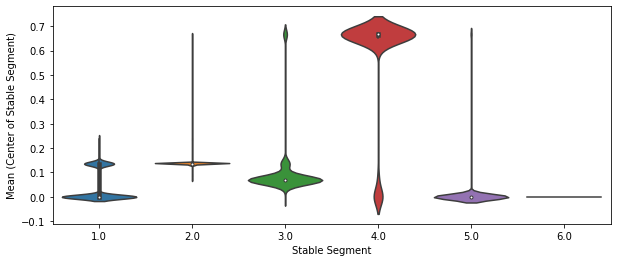

In [15]:
fig = plt.figure(figsize=(10,4))
sns.violinplot(x='stable_n', y='c_center', data=df_stable_center, scale='width')
plt.xlabel('Stable Segment')
plt.ylabel('Mean (Center of Stable Segment)')
plt.show()

## step3:根据稳定时段的中心值对798个批次做时段划分
只有11个批次具有第6个稳定时段，剩余的5个时段集中分布在5个中心值附近，这5个中心值分别是dict_c_center的前五个值，聚类方法：从左到右侧依次做聚类,如果用聚类算法不能保障从左到右的顺序
### 方法1:时段划分结果是6的去掉1个时段，时段划分结果是5的合并过渡时段，时段划分结果是4的补充1个时段，时段划分结果是3的补充2个时段，时段划分结果是2的只有1个批次划分不出来更多的时段了

In [18]:
# 以某一片wafer为例说明，聚类算法不能保证划分结果是从左到右排序的
init_center = [dict_c_center.get(f'c_center_{c}') for c in range(0, c_max-1)]
init_center = np.reshape(init_center, (5,1))
print(np.shape(init_center))
print(init_center)
for wafer_id, group in data_group:
    model = KMeans(n_clusters=5, init=init_center, n_init=1) # 指定了初始化的中心值，那么n_init这个参数表示随机多少次选择初始化中心可以设置成1
    model.fit(np.reshape(group['RETAINER_RING_PRESSURE'].values, (-1,1)))
    print(model.cluster_centers_)
    print(model.labels_)
    break

(5, 1)
[[0.03902121]
 [0.13570543]
 [0.1004835 ]
 [0.58890134]
 [0.00811514]]
[[6.81297245e-02]
 [1.39827819e-01]
 [1.04608632e-01]
 [6.09757470e-01]
 [2.77555756e-17]]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 1 1 3 3 3 3 3 3 3 3 3 3 3 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]


In [19]:
# 从左到右按照顺序聚类
c_center = [dict_c_center.get(f'c_center_{c}') for c in range(0, c_max-1)]
c_center

[0.03902120901099179,
 0.13570542634354915,
 0.10048350074673121,
 0.588901341003044,
 0.008115144520308405]

## 保存5个稳定时段的聚类中心

In [155]:
with open('./data phm 2016/c_center.pickle', 'wb') as f:
    pickle.dump(c_center, f)

In [20]:
# def segment_partition(dseq, c_center):
dseq = data_group.get_group(-4216160666)['RETAINER_RING_PRESSURE'].values
dseq

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.62216533, 0.23738113, 0.23701536,
       0.23738113, 0.23738113, 0.23701536, 0.2366496 , 0.23628383,
       0.18836869, 0.13825896, 0.13606437, 0.13643014, 0.13606437,
       0.13533285, 0.13606437, 0.13606437, 0.13606437, 0.13643014,
       0.13606437, 0.13606437, 0.13606437, 0.13569861, 0.13643014,
       0.13643014, 0.13569861, 0.13569861, 0.13606437, 0.13606437,
       0.13643014, 0.13569861, 0.13606437, 0.13569861, 0.13569861,
       0.13606437, 0.13606437, 0.13606437, 0.13643014, 0.13569861,
       0.13606437, 0.13606437, 0.13606437, 0.13569861, 0.13569861,
       0.13643014, 0.13569861, 0.13569861, 0.13606437, 0.13606437,
       0.13606437, 0.13569861, 0.13569861, 0.13606437, 0.13606437,
       0.13569861, 0.13606437, 0.13606437, 0.13569861, 0.13533285,
       0.13569861, 0.13569861, 0.13569861, 0.13569861, 0.13569861,
       0.13569861, 0.13569861, 0.13606437, 0.13569861, 0.13569

In [21]:
dist_center = []
for center in c_center:
    dist_center.append(np.abs((dseq-center)))

In [22]:
# 可选运行
from utils.wkmb import WKM
dseq_t = np.reshape(dseq, (-1,1))
num_k = 5
delta = 0.0
w = WKM(dseq_t, num_k, delta)
w.cluster()
print(w.boundaries)
print(w.centroids)

[0, 16, 134, 136, 156]
[[0.15435259692757863], [0.13593728689571383], [0.2249451353328456], [0.08094367227505485], [0.30991086184941347]]


In [23]:
# 合并过渡时段
def merge_transient_process(pressure_data:list, b_stable:list, c_center:list):
    b_stable_update_tmp = [0] # update b_stable including transient process
    
    for i in range(0, int(len(b_stable)/2)-1):
        b_backward_right = b_stable[2*i+1]
        b_foreward_left = b_stable[2*i+2]
        
        if (b_backward_right==b_foreward_left):
            # 没有过渡过程
            b_stable_update_tmp.extend([b_backward_right])
        else:
            transient_process = pressure_data[b_backward_right:b_foreward_left]
#             print(b_backward_right, b_foreward_left, pressure_data[b_backward_right:b_foreward_left]) # index
#             print(c_center[i], c_center[i+1])

            dist_to_center = []
            dist_to_center.append(np.abs(transient_process - c_center[i]))
            dist_to_center.append(np.abs(transient_process - c_center[i+1]))
            class_transient_process = np.argmin(dist_to_center, axis=0)
#             print(class_transient_process)

            # np.bincount(array-like)表示[0,max(array)]全闭区间内的元素出现的次数
            if np.argmax(np.bincount(class_transient_process))==0:
                b_stable_update_tmp.extend([b_foreward_left])
            else:
                b_stable_update_tmp.extend([b_backward_right])

#             print(b_stable_update_tmp)
#             print('\n')
    b_stable_update_tmp.extend([len(pressure_data)])
    
    return b_stable_update_tmp

In [25]:
# 时段划分结果是5的，过渡时段合并起来
df_seg_5 = df_stable_seg[df_stable_seg['n_stable_segment']==5].copy()
df_b_stable_update = pd.DataFrame(columns=['b_stable_update'])
for wafer_id in df_seg_5.index:
#     print(wafer_id)
    b_stable = df_seg_5.loc[wafer_id, ['b_stable']].values[0]
#     print(b_stable)
    pressure_data = data_group.get_group(wafer_id)['RETAINER_RING_PRESSURE'].values
    
    b_stable_update_tmp = merge_transient_process(pressure_data, b_stable, c_center)
#     print(b_stable_update_tmp)
#     print('\n')
    
    df_b_stable_update.loc[wafer_id, 'b_stable_update'] = b_stable_update_tmp

df_b_stable_update.index = df_b_stable_update.index.set_names('WAFER_ID')
df_b_stable_update

,b_stable_update
WAFER_ID,
-4230160598,"[0, 17, 138, 159, 169, 187]"
-4230160428,"[0, 16, 138, 158, 170, 187]"
-4230160424,"[0, 17, 141, 161, 171, 188]"
-4230160408,"[0, 17, 138, 160, 170, 187]"
-4228160702,"[0, 17, 143, 162, 172, 189]"
...,...
4229773652,"[0, 17, 133, 164, 174, 191]"
4229773698,"[0, 9, 132, 155, 165, 183]"
4229773718,"[0, 19, 144, 163, 173, 190]"


In [24]:
# 输出所有的初步划分结果是6
df_seg_6 = df_stable_seg[df_stable_seg['n_stable_segment']==6].copy()
df_seg_6

,n_stable_segment,b_stable
WAFER_ID,,
-4226160416,6,"[0, 9, 10, 17, 18, 134, 137, 151, 156, 165, 16..."
-903170168,6,"[0, 9, 19, 27, 28, 133, 136, 150, 155, 165, 16..."
-897170414,6,"[0, 12, 13, 20, 21, 127, 131, 145, 150, 159, 1..."
1306253578,6,"[0, 18, 19, 26, 27, 138, 141, 154, 159, 169, 1..."
2975014168,6,"[0, 10, 19, 28, 30, 140, 143, 155, 161, 170, 1..."
2977014368,6,"[0, 28, 37, 44, 46, 153, 156, 170, 175, 185, 1..."
2979014184,6,"[0, 19, 20, 27, 28, 137, 141, 155, 160, 170, 1..."
3027014502,6,"[0, 15, 16, 24, 25, 134, 139, 147, 150, 169, 1..."
3623681102,6,"[0, 19, 20, 27, 29, 146, 149, 167, 169, 179, 1..."


-4226160416


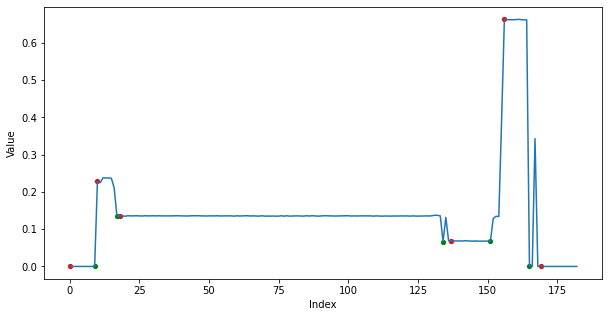

-903170168


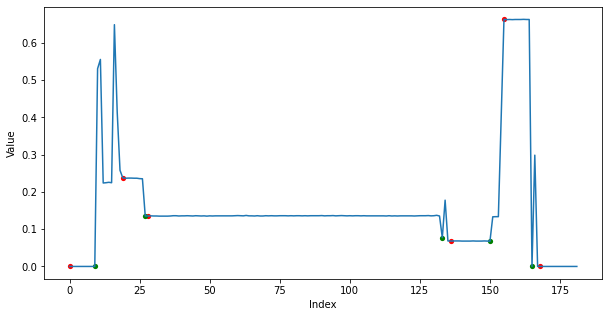

-897170414


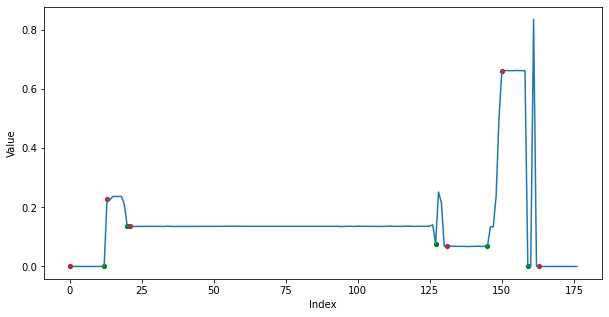

1306253578


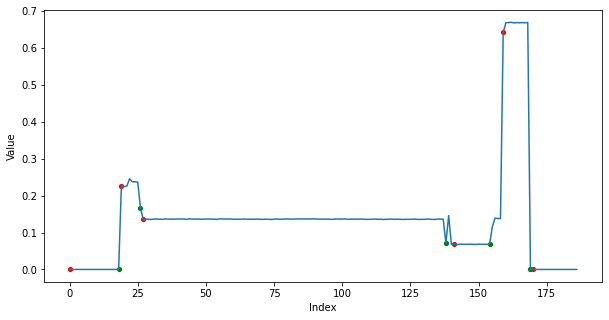

2975014168


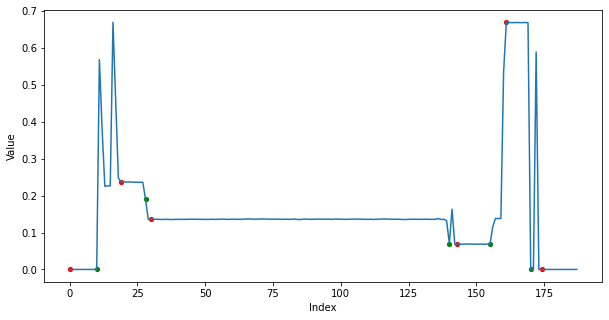

2977014368


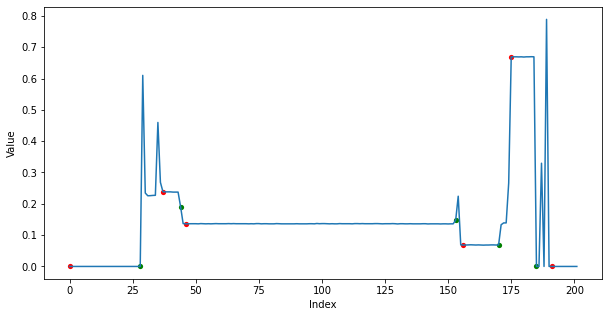

2979014184


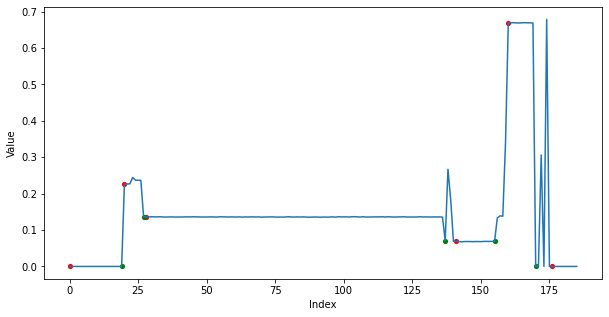

3027014502


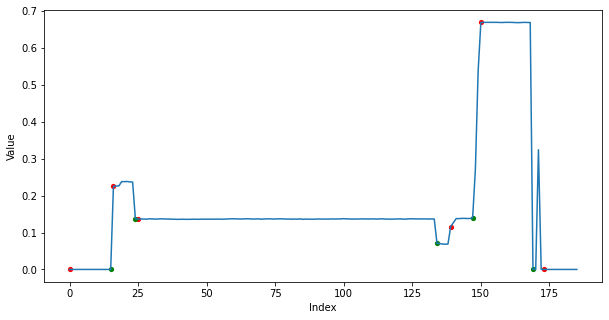

3623681102


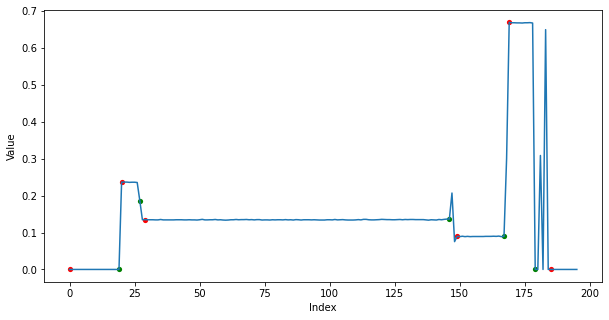

4167773572


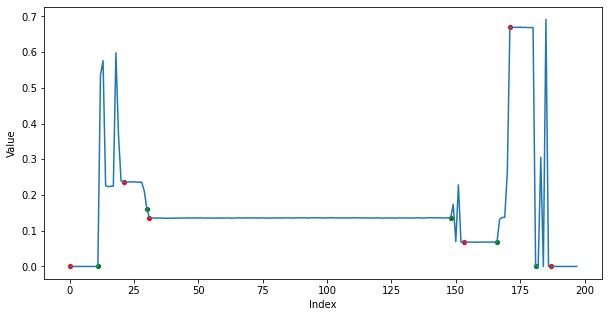

4189773402


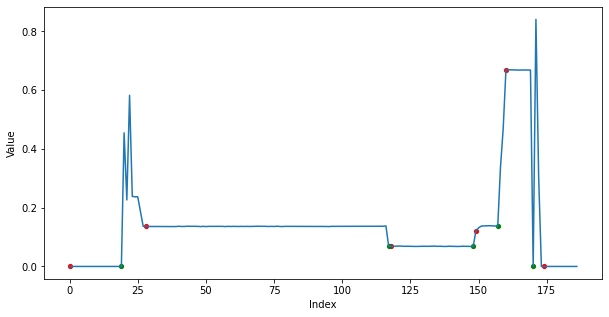

In [27]:
# 输出所有的初步划分是6个时间段的轨迹图像，发现第2个阶段的是多划分出来的，它的变化值刚好卡在了阈值上，单独划分到前面或者是后面
for wafer_id in df_seg_6.index:
    print(wafer_id)
    dseq = data_group.get_group(wafer_id)['RETAINER_RING_PRESSURE'].values
    b_stable = df_seg_6.loc[wafer_id, 'b_stable']
#     print(b_stable)  

    plot_curve(dseq, b_stable)

In [28]:
for wafer_id in df_seg_6.index:
    print(wafer_id)
    dseq = data_group.get_group(wafer_id)['RETAINER_RING_PRESSURE'].values
    b_stable = df_seg_6.loc[wafer_id, 'b_stable'].copy()
    print(b_stable)
    
    # 选第一个长度最小的那段
    p_list = [b_stable[2*i+1]-b_stable[2*i] for i in range(0, int(len(b_stable)/2))]
    print(p_list)
    
    min_len_stable, index_min_len_stable = len(dseq), len(dseq)
    for i in range(0, int(len(b_stable)/2)):
        if (b_stable[2*i+1]-b_stable[2*i]) < min_len_stable:
            min_len_stable, index_min_len_stable = (b_stable[2*i+1]-b_stable[2*i]), i
    print(min_len_stable, index_min_len_stable)
    
    # 对这段进行索引，把它分到前面或者后面的时段里边
    b_left_unique = 2*index_min_len_stable
    b_right_unique = 2*index_min_len_stable+1
    print(b_stable[b_left_unique], b_stable[b_right_unique])
    unique_process = dseq[b_stable[b_left_unique]:b_stable[b_right_unique]]
    dist_unique_process = []
    dist_unique_process.append(np.abs(unique_process-c_center[index_min_len_stable-1])) # 默认这里没有处理端点
    dist_unique_process.append(np.abs(unique_process-c_center[index_min_len_stable])) # 默认这里没有处理端点
    class_unique_process = np.argmin(dist_unique_process, axis=0)
    print(class_unique_process)
    
    b_stable_update = b_stable.copy() # 复制list务必使用copy，不能直接使用等号
    if np.argmax(np.bincount(class_unique_process))==0:
        # 放到前一段，先删除特别时段的左起点和右终点，再修改前一段的右终点，顺序不能变哦
        b_stable_update.remove(b_stable[b_left_unique])
        b_stable_update.remove(b_stable[b_right_unique])
        b_stable_update[2*(index_min_len_stable-1)+1] = b_stable[b_right_unique]
    else: # np.argmax(np.bincount(class_unique_process))==1
        # 放到后一段,先修改后一段的左起点，再删除特别时段的左起点和右起点，顺序不能变哦
        b_stable_update[2*(index_min_len_stable+1)] = b_stable[b_left_unique]
        b_stable_update.remove(b_stable[b_left_unique]) # list.remove函数比较特别，它删除第一次出现的某个值
        b_stable_update.remove(b_stable[b_right_unique])
        
    print(b_stable_update)
    
    # 合并过渡的时间段：
    b_stable_update_tmp = merge_transient_process(dseq, b_stable_update, c_center)
    print(b_stable_update_tmp)
    print('\n')
    
    df_b_stable_update.loc[wafer_id, 'b_stable_update'] = b_stable_update_tmp

df_b_stable_update

-4226160416
[0, 9, 10, 17, 18, 134, 137, 151, 156, 165, 169, 183]
[9, 7, 116, 14, 9, 14]
7 1
10 17
[1 1 1 1 1 1 1]
[0, 9, 10, 134, 137, 151, 156, 165, 169, 183]
[0, 10, 134, 156, 165, 183]


-903170168
[0, 9, 19, 27, 28, 133, 136, 150, 155, 165, 168, 182]
[9, 8, 105, 14, 10, 14]
8 1
19 27
[1 1 1 1 1 1 1 1]
[0, 9, 19, 133, 136, 150, 155, 165, 168, 182]
[0, 9, 133, 155, 165, 182]


-897170414
[0, 12, 13, 20, 21, 127, 131, 145, 150, 159, 163, 177]
[12, 7, 106, 14, 9, 14]
7 1
13 20
[1 1 1 1 1 1 1]
[0, 12, 13, 127, 131, 145, 150, 159, 163, 177]
[0, 13, 131, 150, 159, 177]


1306253578
[0, 18, 19, 26, 27, 138, 141, 154, 159, 169, 170, 187]
[18, 7, 111, 13, 10, 17]
7 1
19 26
[1 1 1 1 1 1 1]
[0, 18, 19, 138, 141, 154, 159, 169, 170, 187]
[0, 19, 138, 159, 169, 187]


2975014168
[0, 10, 19, 28, 30, 140, 143, 155, 161, 170, 174, 188]
[10, 9, 110, 12, 9, 14]
9 1
19 28
[1 1 1 1 1 1 1 1 1]
[0, 10, 19, 140, 143, 155, 161, 170, 174, 188]
[0, 10, 140, 161, 170, 188]


2977014368
[0, 28, 37, 44, 46, 15

,b_stable_update
WAFER_ID,
-4230160598,"[0, 17, 138, 159, 169, 187]"
-4230160428,"[0, 16, 138, 158, 170, 187]"
-4230160424,"[0, 17, 141, 161, 171, 188]"
-4230160408,"[0, 17, 138, 160, 170, 187]"
-4228160702,"[0, 17, 143, 162, 172, 189]"
...,...
2979014184,"[0, 20, 141, 160, 170, 186]"
3027014502,"[0, 16, 134, 150, 169, 186]"
3623681102,"[0, 20, 149, 169, 179, 196]"


In [29]:
# 时段划分结果是4的，把第1个时段检测出来【没有完成】
df_seg_4 = df_stable_seg[df_stable_seg['n_stable_segment']==4].copy()
for wafer_id in df_seg_4.index: #[-4228160604][-4224160662]
    dseq = data_group.get_group(wafer_id)['RETAINER_RING_PRESSURE'].values
    print(wafer_id, len(dseq))
    b_stable = df_seg_4.loc[wafer_id, ['b_stable']].values[0]
    print(b_stable)
    
    b_stable_update = b_stable.copy()
    if (b_stable[0] != 0): # 没有头的把[0,b_stable的第0个元素]加在b_stable的最前面
        b_stable_update.insert(0, b_stable[0])
        b_stable_update.insert(0, 0)
    else: # if (b_stable[0] == 0): # 长度长的过渡过程单独作为一个时段  
        i, j = 1, 2
        if (b_stable[2*(i+1)] - b_stable[2*i+1]) >= (b_stable[2*(j+1)] - b_stable[2*j+1]) :
            b_stable_update.insert(2*(i+1), b_stable[2*(i+1)])
            b_stable_update.insert(2*(i+1), b_stable[2*i+1])
        else:
            b_stable_update.insert(2*(j+1), b_stable[2*(j+1)])
            b_stable_update.insert(2*(j+1), b_stable[2*j+1])
    
    print(b_stable_update)
    # 合并过渡的时间段：
    b_stable_update_tmp = merge_transient_process(dseq, b_stable_update, c_center)
    print(b_stable_update_tmp)
    print('\n')
    df_b_stable_update.loc[wafer_id, 'b_stable_update'] = b_stable_update_tmp
df_b_stable_update

-4228160604 197
[0, 17, 25, 147, 162, 178, 185, 197]
[0, 17, 25, 147, 147, 162, 162, 178, 185, 197]
[0, 17, 147, 162, 185, 197]


-4224160662 172
[0, 7, 16, 131, 135, 145, 152, 172]
[0, 7, 16, 131, 135, 145, 145, 152, 152, 172]
[0, 7, 135, 145, 152, 172]


-4216160666 183
[17, 133, 137, 151, 156, 166, 172, 183]
[0, 17, 17, 133, 137, 151, 156, 166, 172, 183]
[0, 17, 137, 156, 166, 183]


-4041511860 182
[0, 19, 28, 133, 136, 150, 167, 182]
[0, 19, 28, 133, 136, 150, 150, 167, 167, 182]
[0, 19, 133, 150, 167, 182]


-4037511828 169
[13, 119, 122, 137, 143, 152, 156, 169]
[0, 13, 13, 119, 122, 137, 143, 152, 156, 169]
[0, 13, 122, 143, 156, 169]


-4033511524 188
[9, 134, 137, 150, 155, 164, 169, 188]
[0, 9, 9, 134, 137, 150, 155, 164, 169, 188]
[0, 9, 134, 155, 164, 188]


-4027511790 175
[12, 126, 130, 144, 149, 159, 165, 175]
[0, 12, 12, 126, 130, 144, 149, 159, 165, 175]
[0, 12, 130, 149, 159, 175]


-4027511568 175
[14, 126, 129, 143, 148, 158, 163, 175]
[0, 14, 14, 126, 129, 143, 14

,b_stable_update
WAFER_ID,
-4230160598,"[0, 17, 138, 159, 169, 187]"
-4230160428,"[0, 16, 138, 158, 170, 187]"
-4230160424,"[0, 17, 141, 161, 171, 188]"
-4230160408,"[0, 17, 138, 160, 170, 187]"
-4228160702,"[0, 17, 143, 162, 172, 189]"
...,...
3846719100,"[0, 13, 135, 155, 165, 182]"
4167773604,"[0, 13, 126, 145, 154, 169]"
4181773512,"[0, 14, 124, 145, 154, 171]"


In [30]:
# 时段划分结果是3的
df_seg_3 = df_stable_seg[df_stable_seg['n_stable_segment']==3].copy()
df_seg_3

,n_stable_segment,b_stable
WAFER_ID,,
29494162,3,"[12, 110, 130, 147, 153, 164]"
3029014464,3,"[13, 117, 121, 134, 145, 156]"
3031014466,3,"[0, 16, 25, 134, 135, 150]"
4209773434,3,"[13, 115, 116, 137, 156, 170]"


In [25]:
def partition_with_center(dseq:list, c_center:list):
    """
    返回值：
    class_labels:类的标签
    b_stable:左起点和右终点，例如[0,7,8,19]表示[0,7)和[8,19)两段
    b_stable_update:分割点，例如[0,7,19]表示[0,7)和[7,19)两段
    """
    i = 0
    class_labels = []
    for j,item in enumerate(dseq):
#         print(j, item, i, class_dseq)
        if (i==len(c_center)-1) & (j!=len(dseq)):
            class_labels.extend([i])
        else:
            dist_0 = np.abs(item - c_center[i])
            dist_1 = np.abs(item - c_center[i+1])
            if dist_0 <= dist_1:
                class_labels.extend([i])
            else:
                class_labels.extend([i+1])
#             print(j, class_dseq)

            if (j!=0) & (class_labels[j] != class_labels[j-1]):
                i+=1
    
    b_stable_update = list(np.cumsum(np.bincount(class_labels)))
    b_stable_update.insert(0,0)
    
    b_stable = []
    for it,iz in zip(b_stable_update[0:-1], b_stable_update[1::]):
        b_stable.extend([it,iz])
    
    return class_labels, b_stable, b_stable_update
                

In [32]:
# 从这里开始使用划分函数partition_with_center
for wafer_id in df_seg_3.index: #[3031014466]: #
    dseq = data_group.get_group(wafer_id)['RETAINER_RING_PRESSURE'].values
    b_stable = df_seg_3.loc[wafer_id, 'b_stable'].copy()
    
    print(wafer_id, len(dseq), b_stable)
    
    class_labels, b_stable, b_stable_update = partition_with_center(dseq, c_center)
    print(b_stable)
    print(b_stable_update)
    print('\n')
    
    df_b_stable_update.loc[wafer_id, 'b_stable_update'] = b_stable_update_tmp
    
df_b_stable_update

29494162 164 [12, 110, 130, 147, 153, 164]
[0, 5, 5, 113, 113, 130, 130, 147, 147, 164]
[0, 5, 113, 130, 147, 164]


3029014464 156 [13, 117, 121, 134, 145, 156]
[0, 5, 5, 120, 120, 139, 139, 144, 144, 156]
[0, 5, 120, 139, 144, 156]


3031014466 166 [0, 16, 25, 134, 135, 150]
[0, 17, 17, 134, 134, 153, 153, 159, 159, 166]
[0, 17, 134, 153, 159, 166]


4209773434 170 [13, 115, 116, 137, 156, 170]
[0, 6, 6, 115, 115, 142, 142, 147, 147, 170]
[0, 6, 115, 142, 147, 170]




,b_stable_update
WAFER_ID,
-4230160598,"[0, 17, 138, 159, 169, 187]"
-4230160428,"[0, 16, 138, 158, 170, 187]"
-4230160424,"[0, 17, 141, 161, 171, 188]"
-4230160408,"[0, 17, 138, 160, 170, 187]"
-4228160702,"[0, 17, 143, 162, 172, 189]"
...,...
4219773496,"[0, 12, 125, 147, 157, 173]"
29494162,"[0, 12, 125, 147, 157, 173]"
3029014464,"[0, 12, 125, 147, 157, 173]"


In [33]:
# 时段划分是2的结果
df_seg_2 = df_stable_seg[df_stable_seg['n_stable_segment']==2].copy()
df_seg_2 # 这段只有两个部分，所以省略掉了这个部分

,n_stable_segment,b_stable
WAFER_ID,,
4167773580,2,"[0, 18, 27, 145]"


[0, 19, 19, 145, 145, 151]


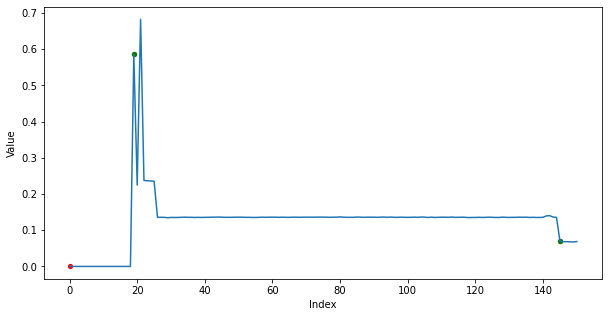

In [34]:
dseq = data_group.get_group(4167773580)['RETAINER_RING_PRESSURE'].values
_, b_stable, b_stable_update = partition_with_center(dseq, c_center)
print(b_stable)
plot_curve(dseq, b_stable)

### 方法2:用划分函数partiion_with_center
这种方法效率更高～最后采用了这种方法～

In [26]:
# 划分结果保存在df_stable_seg_update中
# n_stable_segment表示时段的个数
# b_stable表示时段的左起点和右终点，例如[1,2,4,5]表示2个时段分别是[1,2)和[4,5)
# b_stable_update表示分割点，例如[1,4,7]表示2个时段分别是[1,4)和[4,7)
df_stable_seg_update = pd.DataFrame(columns=['n_stable_segment', 'b_stable', 'b_stable_update'])
for wafer_id, group in data_group:
    dseq = group['RETAINER_RING_PRESSURE'].values
    class_labels, b_stable, b_stable_update = partition_with_center(dseq, c_center)
    
    df_stable_seg_update.loc[wafer_id, 'b_stable'] = b_stable
    df_stable_seg_update.loc[wafer_id, 'n_stable_segment'] = len(b_stable_update)-1
    df_stable_seg_update.loc[wafer_id, 'b_stable_update'] = b_stable_update

df_stable_seg_update.index = df_stable_seg_update.index.set_names('WAFER_ID')
df_stable_seg_update

,n_stable_segment,b_stable,b_stable_update
WAFER_ID,,,
-4230160598,5,"[0, 18, 18, 138, 138, 158, 158, 169, 169, 187]","[0, 18, 138, 158, 169, 187]"
-4230160428,5,"[0, 17, 17, 138, 138, 158, 158, 170, 170, 187]","[0, 17, 138, 158, 170, 187]"
-4230160424,5,"[0, 18, 18, 140, 140, 160, 160, 171, 171, 188]","[0, 18, 140, 160, 171, 188]"
-4230160408,5,"[0, 18, 18, 138, 138, 159, 159, 170, 170, 187]","[0, 18, 138, 159, 170, 187]"
-4228160702,5,"[0, 18, 18, 142, 142, 162, 162, 172, 172, 189]","[0, 18, 142, 162, 172, 189]"
...,...,...,...
4229773652,5,"[0, 18, 18, 127, 127, 164, 164, 174, 174, 191]","[0, 18, 127, 164, 174, 191]"
4229773698,5,"[0, 10, 10, 132, 132, 155, 155, 165, 165, 183]","[0, 10, 132, 155, 165, 183]"
4229773718,5,"[0, 20, 20, 140, 140, 162, 162, 173, 173, 190]","[0, 20, 140, 162, 173, 190]"


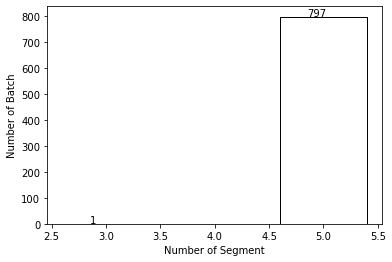

In [27]:
plot_bar(df_stable_seg_update)

WAFER_ID = 4167773580
b_stable_origin = [0, 18, 27, 145]
b_stable_new = [0, 19, 19, 145, 145, 151]


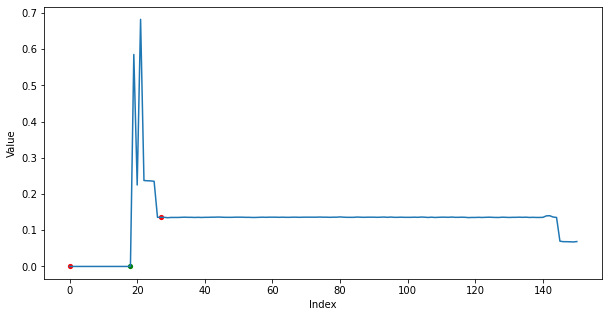

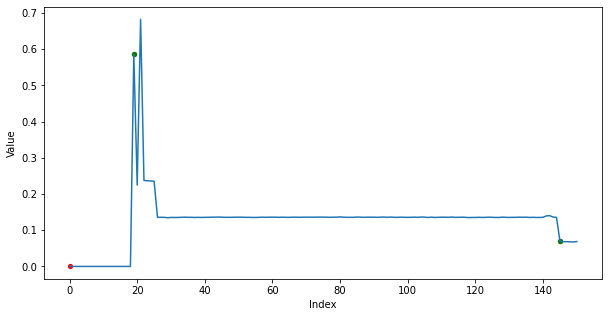

In [637]:
# 某个原始时段划分结果和新的时段划分结果的展示
# wafer_id = -4226160416 # 原始时段划分结果是6
# wafer_id = -4230160424 # 原始时段划分结果是5
# wafer_id = -4224160662 # 原始时段划分结果是4
# wafer_id = 29494162 # 原始时段划分结果是3
wafer_id = 4167773580 # 原始时段划分结果是2
dseq = data_group.get_group(wafer_id)['RETAINER_RING_PRESSURE'].values
b_stable = df_stable_seg.loc[wafer_id, 'b_stable']
b_stable_new = df_stable_seg_update.loc[wafer_id, 'b_stable']
print(f'WAFER_ID = {wafer_id}')
print(f'b_stable_origin = {b_stable}')
print(f'b_stable_new = {b_stable_new}')
plot_curve(dseq, b_stable)
plot_curve(dseq, b_stable_new)

## 保存时段划分后的数据
首先保存稳定时段的划分结果

In [43]:
df_stable_seg_update.to_csv('./data phm 2016/df_stable_seg_update.csv')

## 划分时段（划分所有的变量）
所有的数据根据训练集的均值和标准差归一化之后，划分成5个稳定时段，各自保存训练集和测试集的稳定时段的数据

In [246]:
def str_to_list(x:list):
    # 处理从csv中读出来的[]并不是数字格式，从str格式转换成数字格式
    result = []
    str_tmp = x.split('[')[1].split(']')[0].split(',')
    result = [int(item) for item in str_tmp]
    
    return result

In [245]:
# 读取时段划分的结果(注意读取文件中保存的结果的时候需要将str转换成list)
df_stable_seg_update = pd.read_csv('./data phm 2016/df_stable_seg_update_train.csv', index_col='WAFER_ID')
df_stable_seg_update['b_stable_update'] = df_stable_seg_update['b_stable_update'].apply(str_to_list)
df_stable_seg_update

,n_stable_segment,b_stable,b_stable_update
WAFER_ID,,,
-4230160598,5,"[0, 18, 18, 138, 138, 158, 158, 169, 169, 187]","[0, 18, 138, 158, 169, 187]"
-4230160428,5,"[0, 17, 17, 138, 138, 158, 158, 170, 170, 187]","[0, 17, 138, 158, 170, 187]"
-4230160424,5,"[0, 18, 18, 140, 140, 160, 160, 171, 171, 188]","[0, 18, 140, 160, 171, 188]"
-4230160408,5,"[0, 18, 18, 138, 138, 159, 159, 170, 170, 187]","[0, 18, 138, 159, 170, 187]"
-4228160702,5,"[0, 18, 18, 142, 142, 162, 162, 172, 172, 189]","[0, 18, 142, 162, 172, 189]"
...,...,...,...
4229773652,5,"[0, 18, 18, 127, 127, 164, 164, 174, 174, 191]","[0, 18, 127, 164, 174, 191]"
4229773698,5,"[0, 10, 10, 132, 132, 155, 155, 165, 165, 183]","[0, 10, 132, 155, 165, 183]"
4229773718,5,"[0, 20, 20, 140, 140, 162, 162, 173, 173, 190]","[0, 20, 140, 162, 173, 190]"


In [133]:
Train_seg = {}
for i in range(0,5):
    Train_seg[f'seg_{i}'] = {}
Train_seg

{'seg_0': {}, 'seg_1': {}, 'seg_2': {}, 'seg_3': {}, 'seg_4': {}}

In [134]:
for wafer_id, group in data.groupby(['WAFER_ID']):
    b_stable_update = df_stable_seg_update.loc[wafer_id, 'b_stable_update']
    df_tmp = group.reset_index(drop=True)
                           
    for i,j in enumerate(zip(b_stable_update[:-1], b_stable_update[1:])):
        Train_seg.get(f'seg_{i}')[wafer_id] = df_tmp.iloc[j[0]:j[1],:]

In [135]:
for i in range(0,5):
    print(len(Train_seg.get(f'seg_{i}')))

798
798
798
797
797


In [140]:
# 存储为pickle文件
with open('./data phm 2016/Train_seg.dict', 'wb') as f:
    pickle.dump(Train_seg, f)

In [141]:
# 读取pickle文件验证成功
with open('./data phm 2016/Train_seg.dict', 'rb') as f:
    Train_seg = pickle.load(f)
for i in range(0,5):
    print(len(Train_seg.get(f'seg_{i}')))

In [56]:
# 删除WAFER_ID=4167773580，因为原始时段划分结果是2重新划分结果还是3个阶段，分不出来5个阶段，这个批次的轨迹分不出来5个阶段
# df_stable_seg_update = df_stable_seg_update.drop([4167773580], axis=0)
# 训练的时候想着删除这条数据

pandas.core.groupby.generic.DataFrameGroupBy

# 测试集划分时段

In [36]:
# 导入模态I测试集数据，已经归一化
data_test = pd.read_csv('./data phm 2016/Test_data_modeI_chamber4_mm.csv')
data_test = data_test.drop(['Unnamed: 0'], axis=1)
data_test

,MACHINE_ID,MACHINE_DATA,TIMESTAMP,WAFER_ID,STAGE,CHAMBER,USAGE_OF_BACKING_FILM,USAGE_OF_DRESSER,USAGE_OF_POLISHING_TABLE,USAGE_OF_DRESSER_TABLE,...,USAGE_OF_PRESSURIZED_SHEET,SLURRY_FLOW_LINE_A,SLURRY_FLOW_LINE_B,SLURRY_FLOW_LINE_C,WAFER_ROTATION,STAGE_ROTATION,HEAD_ROTATION,DRESSING_WATER_STATUS,EDGE_AIR_BAG_PRESSURE,AVG_REMOVAL_RATE
0,2,4,4.816380e+08,-4224160592,A,4,0.885617,0.690257,0.894967,0.001372,...,0.885617,0.053691,1,0.000000,0.0,0.0,0.833333,1,0.0,56.1786
1,2,4,4.816380e+08,-4224160592,A,4,0.885617,0.690257,0.894967,0.001372,...,0.885617,0.083893,1,0.049223,0.0,0.0,0.833333,1,0.0,56.1786
2,2,4,4.816380e+08,-4224160592,A,4,0.885617,0.690257,0.894967,0.001372,...,0.885617,0.335570,1,0.222798,0.0,0.0,0.833333,1,0.0,56.1786
3,2,4,4.816380e+08,-4224160592,A,4,0.885617,0.690257,0.894967,0.001372,...,0.885617,0.412752,1,0.279793,0.0,0.0,0.833333,1,0.0,56.1786
4,2,4,4.816380e+08,-4224160592,A,4,0.885617,0.690257,0.894967,0.001372,...,0.885617,0.469799,1,0.339378,0.0,0.0,0.833333,1,0.0,56.1786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30595,2,4,4.872162e+08,33494174,A,4,0.030640,0.842462,0.984683,0.993140,...,0.030640,0.053691,1,0.000000,0.0,0.0,0.833333,1,0.0,70.7889
30596,2,4,4.872162e+08,33494174,A,4,0.030640,0.842462,0.984683,0.993140,...,0.030640,0.053691,1,0.000000,0.0,0.0,0.833333,1,0.0,70.7889
30597,2,4,4.872162e+08,33494174,A,4,0.030640,0.842462,0.984683,0.993140,...,0.030640,0.053691,1,0.000000,0.0,0.0,0.833333,1,0.0,70.7889
30598,2,4,4.872162e+08,33494174,A,4,0.030640,0.842462,0.984683,0.993140,...,0.030640,0.053691,1,0.000000,0.0,0.0,0.833333,1,0.0,70.7889


In [37]:
# 保存wafer id
wafer_id_test = []
for wafer_id, group in data_test.groupby(['WAFER_ID']):
    wafer_id_test.append(wafer_id)
with open('./data phm 2016/wafer_id_test_modeI_chamber4.list', 'wb') as f:
    pickle.dump(wafer_id_test, f)

In [146]:
# 提取RETAINER_RING_PRESSURE作为时段划分的依据
df_data_test = data_test[['WAFER_ID', 'RETAINER_RING_PRESSURE']]
data_group_test = df_data_test.groupby(by=['WAFER_ID'])

In [148]:
len(df_data_test['WAFER_ID'].unique())

165

In [153]:
# 根据5个稳定时段的center中心粗略划分时段
# 划分结果保存在df_stable_seg_update中
# n_stable_segment表示时段的个数
# b_stable表示时段的左起点和右终点，例如[1,2,4,5]表示2个时段分别是[1,2)和[4,5)
# b_stable_update表示分割点，例如[1,4,7]表示2个时段分别是[1,4)和[4,7)
df_stable_seg_update_test = pd.DataFrame(columns=['n_stable_segment', 'b_stable', 'b_stable_update'])
for wafer_id, group in data_group_test:
    dseq = group['RETAINER_RING_PRESSURE'].values
    class_labels, b_stable, b_stable_update = partition_with_center(dseq, c_center)
    
    df_stable_seg_update_test.loc[wafer_id, 'b_stable'] = b_stable
    df_stable_seg_update_test.loc[wafer_id, 'n_stable_segment'] = len(b_stable_update)-1
    df_stable_seg_update_test.loc[wafer_id, 'b_stable_update'] = b_stable_update

df_stable_seg_update_test.index = df_stable_seg_update_test.index.set_names('WAFER_ID')
df_stable_seg_update_test

,n_stable_segment,b_stable,b_stable_update
WAFER_ID,,,
-4226160404,5,"[0, 15, 15, 143, 143, 164, 164, 174, 174, 198]","[0, 15, 143, 164, 174, 198]"
-4224160686,5,"[0, 18, 18, 144, 144, 165, 165, 176, 176, 193]","[0, 18, 144, 165, 176, 193]"
-4224160592,5,"[0, 17, 17, 139, 139, 160, 160, 170, 170, 188]","[0, 17, 139, 160, 170, 188]"
-4220160654,5,"[0, 17, 17, 140, 140, 161, 161, 171, 171, 188]","[0, 17, 140, 161, 171, 188]"
-4141512092,5,"[0, 20, 20, 142, 142, 162, 162, 173, 173, 191]","[0, 20, 142, 162, 173, 191]"
...,...,...,...
4217773710,5,"[0, 5, 5, 126, 126, 147, 147, 156, 156, 175]","[0, 5, 126, 147, 156, 175]"
4221773698,5,"[0, 16, 16, 141, 141, 160, 160, 170, 170, 188]","[0, 16, 141, 160, 170, 188]"
4223773496,5,"[0, 19, 19, 147, 147, 168, 168, 179, 179, 196]","[0, 19, 147, 168, 179, 196]"


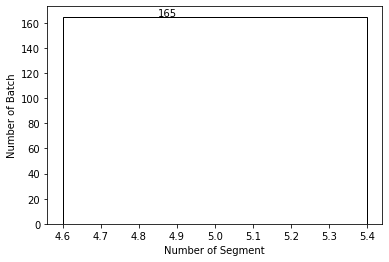

In [161]:
# 测试集划分结果全部是5个稳定时段
plot_bar(df_stable_seg_update_test)

[0, 20, 140, 161, 172, 189]


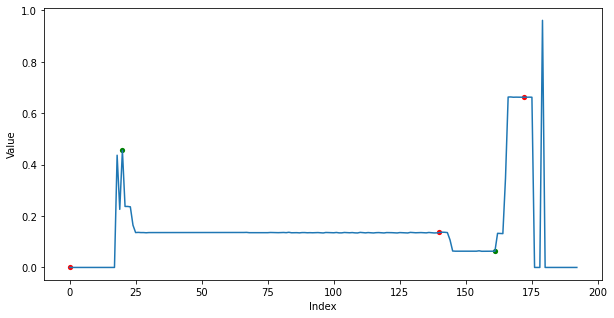

In [165]:
# 查看某个wafer_id的划分结果是否合理,结果可以接受
dseq = data_group_test.get_group(-4224160686)['RETAINER_RING_PRESSURE'].values
b_stable = df_stable_seg_update_test.loc[wafer_id, 'b_stable_update']
print(b_stable_update)

plot_curve(dseq, b_stable)

In [154]:
# 保存
df_stable_seg_update_test.to_csv('./data phm 2016/df_stable_seg_update_test.csv')

In [159]:
# 根据时段划分的端点给测试集数据的全部变量划分时段
Test_seg = {}
for i in range(0,5):
    Test_seg[f'seg_{i}'] = {}

for wafer_id, group in data_test.groupby(['WAFER_ID']):
    b_stable_update = df_stable_seg_update_test.loc[wafer_id, 'b_stable_update']
    df_tmp = group.reset_index(drop=True)
    

    for i,j in enumerate(zip(b_stable_update[:-1], b_stable_update[1:])):
        Test_seg.get(f'seg_{i}')[wafer_id] = df_tmp.iloc[j[0]:j[1],:]

In [160]:
for i in range(0,5):
    print(len(Test_seg.get(f'seg_{i}')))

165
165
165
165
165


In [166]:
# 保存时段划分后的数据
with open('./data phm 2016/Test_seg.dict', 'wb') as f:
    pickle.dump(Test_seg, f)

## 时段补齐
（1）某个时段的每片wafer的时间序列长度是不一致的，那么以最长的时间序列为标准，不足最长时间序列的使用该时段的聚类中心的值补齐（2）补齐之后再保存数据到本地（3）这里需要注意最长时间序列指的是训练集和测试集联合考虑起来的最长

In [271]:
# (1)最长时间长度

In [216]:
def cum_minus(x:list):
    result = []
    for i,j in zip(x[:-1], x[1:]):
        result.extend([j-i])
    
    return result

In [376]:
tmp = df_stable_seg_update['b_stable_update'].copy()
tmp = tmp.apply(cum_minus)
tmp = tmp.drop([4167773580], axis=0) #原始时段划分结果是2重新划分结果还是3个阶段，分不出来5个阶段，这个批次的轨迹分不出来5个阶段,所以删除
list_tmp = []
list_tmp.extend(tmp)
seg_length = np.max(list_tmp,axis=0)

tmp = df_stable_seg_update_test['b_stable_update'].copy()
tmp = tmp.apply(cum_minus)
list_tmp = []
list_tmp.extend(tmp)

seg_length = np.vstack((seg_length, np.max(list_tmp,axis=0)))
seg_length

array([[ 37, 147,  42,  21,  93],
       [ 29, 140,  31,  20,  24]])

In [377]:
seg_length_max = np.max(seg_length, axis=0)
seg_length_max # 最长时间长度

array([ 37, 147,  42,  21,  93])

In [272]:
# （2）每个参数的均值，只考虑训练集

In [400]:
cols_X = ['USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER',
       'USAGE_OF_POLISHING_TABLE', 'USAGE_OF_DRESSER_TABLE',
       'PRESSURIZED_CHAMBER_PRESSURE', 'MAIN_OUTER_AIR_BAG_PRESSURE',
       'CENTER_AIR_BAG_PRESSURE', 'RETAINER_RING_PRESSURE',
       'RIPPLE_AIR_BAG_PRESSURE', 'USAGE_OF_MEMBRANE',
       'USAGE_OF_PRESSURIZED_SHEET', 'SLURRY_FLOW_LINE_A',
       'SLURRY_FLOW_LINE_B', 'SLURRY_FLOW_LINE_C', 'WAFER_ROTATION',
       'STAGE_ROTATION', 'HEAD_ROTATION', 'DRESSING_WATER_STATUS',
       'EDGE_AIR_BAG_PRESSURE']
col_y = ['AVG_REMOVAL_RATE']

In [393]:
# define a dictionary for n_stable_0~5 all samples
# 使用update之后的分割结果
dict_sample_all = {}
for i in range(0, 5):
    dict_sample_all[f'seg_{i}'] = []
dict_sample_all
for i in range(0,5):
    df_samples = pd.DataFrame()
    train_data = Train_seg.get(f'seg_{i}')
    
    #原始时段划分结果是2重新划分结果还是3个阶段，分不出来5个阶段，这个批次的轨迹分不出来5个阶段,所以删除
    if train_data.get(4167773580) is not None:
        train_data.pop(4167773580)
    
    for wafer_id in train_data.keys():
        group = train_data.get(wafer_id)
        df_samples = pd.concat([df_samples, group])
    
    dict_sample_all[f'seg_{i}'] = df_samples

In [395]:
# 平均值
mean_sample = {}
for i in range(0,5):
    mean_sample[f'seg_{i}'] = pd.DataFrame(dict_sample_all[f'seg_{i}'].mean()).transpose()

In [2]:
# （3）使用均值补齐,只保留cols_to_train的那些列
# 训练集部分
Train_seg_X = {}
Train_seg_Y = {}
for i in range(0,5):
    train_data = Train_seg.get(f'seg_{i}')
    
    Y = []
    X = np.zeros((797, seg_length_max[i], len(cols_X))) #(批次数量，批次最长长度，变量个数)
    for j,wafer_id in enumerate(train_data.keys()):
        
        # 处理X
        df_1 = train_data.get(wafer_id)[cols_X]
        df_2 = pd.DataFrame(np.ones((seg_length_max[i] - df_1.shape[0], len(cols_X)))*mean_sample.get(f'seg_{i}')[cols_X].values, columns=cols_X)
        X[j, :, :] = pd.concat([df_1, df_2])
        
        # 处理Y
        Y.extend(train_data.get(wafer_id)[col_y].mean())
        
    Train_seg_X[f'seg_{i}'] = X
    Train_seg_Y[f'seg_{i}'] = Y

NameError: name 'Train_seg' is not defined

In [435]:
# 验证整理数据有效
for i in range(0, 5):
    print(Train_seg_X[f'seg_{i}'].shape, len(Train_seg_Y[f'seg_{i}']))

(797, 37, 19) 797
(797, 147, 19) 797
(797, 42, 19) 797
(797, 21, 19) 797
(797, 93, 19) 797


In [436]:
# 保存数据
with open('./data phm 2016/Train_seg_X_r.dict', 'wb') as f:
    pickle.dump(Train_seg_X, f)
with open('./data phm 2016/Train_seg_Y_r.dict', 'wb') as f:
    pickle.dump(Train_seg_Y, f)

In [437]:
# 测试集部分
Test_seg_X = {}
Test_seg_Y = {}
for i in range(0,5):
    test_data = Test_seg.get(f'seg_{i}')
    
    Y = []
    X = np.zeros((165, seg_length_max[i], len(cols_X)))
    for j,wafer_id in enumerate(test_data.keys()):
        
        # 处理X
        df_1 = test_data.get(wafer_id)[cols_X]
        df_2 = pd.DataFrame(np.ones((seg_length_max[i] - df_1.shape[0], len(cols_X)))*mean_sample.get(f'seg_{i}')[cols_X].values, columns=cols_X)
        X[j, :, :] = pd.concat([df_1, df_2])
        
        # 处理Y
        Y.extend(test_data.get(wafer_id)[col_y].mean())
        
    Test_seg_X[f'seg_{i}'] = X
    Test_seg_Y[f'seg_{i}'] = Y

In [438]:
# 验证整理数据有效
for i in range(0, 5):
    print(Test_seg_X[f'seg_{i}'].shape, len(Test_seg_Y[f'seg_{i}']))

(165, 37, 19) 165
(165, 147, 19) 165
(165, 42, 19) 165
(165, 21, 19) 165
(165, 93, 19) 165


In [439]:
# 保存数据
with open('./data phm 2016/Test_seg_X_r.dict', 'wb') as f:
    pickle.dump(Test_seg_X, f)
with open('./data phm 2016/Test_seg_Y_r.dict', 'wb') as f:
    pickle.dump(Test_seg_Y, f)

In [442]:
tmp = df_stable_seg_update['b_stable_update'].copy()
tmp = tmp.apply(cum_minus)

In [451]:
with open('tmp.txt', 'w') as f:
    f.write(str(tmp.values))